The code below is an implementation of the Q-Learning RL algorithm 
by @guroosh (https://github.com/guroosh/CS7IS2-AI-project/tree/master)
to the following Race Track problem:

Create an "intelligent" racing car, where the car needs to learn to get from
a point S ("start") to a point F ("finish") in the shortest time possible.
Consider the racing ground to be modelled by a simple grid represented by a n x n matrix M(i,j),
where n is an integer comprised between 1 and infinity.
Starting point S is defined as M(1,1) and finish line F at M(n,n). The position of the car at any given
place on the grid is given by its matrix element coordinates (x,y) and formally defined by the matrix
M(i=x,j=y)=1 and M(i≠x,j≠y)=0. The car race starts at time t=1, and the car can move only to the
nearest coordinates in one time step, either vertically, horizontally, or in diagonal (i±1 and/or j±1 at
time t+1).

How would you code this racing car so that it learns by itself the shortest path from S to F through a
model-free reinforcement learning algorithm? 
Would you change the rate of exploration as time increases?

## Set up Environment and Simulation

In [1]:
import time
import tkinter as tk
import random
import numpy as np

# to represent a graph as a Matrix
class Graph:

    def __init__(self, root):
        self.root = root
        self.adjacency_map = {} 

        
class GridWorld:

    def __init__(self, m=20, n=20, master=None):
        
        # Set class variables
        
        self.height = 700
        self.width = 700
        self.agent = ()
        self.agent_ui = ()
        self.length = 0
        self.possible_moves = ()
        self.agent_padding = 0
        self.padding = 30
        self.a_star_visited_count = 0
        self.a_star_opened_count = 0
        self.master = master

        self.m = m
        self.n = n
        self.is_visited = [[0] * self.m for temp in range(self.n)] # zero m x n grid 

        self.start_x = 0
        self.start_y = 0
        self.end_x = self.m - 1
        self.end_y = self.n - 1

        self.start_key = str(self.start_x) + "," + str(self.start_y)
        self.graph = Graph(self.start_key)

        self.color_background = 'snow3'
        self.color_normal = 'white'
        self.color_visited = 'khaki3'

        self.frame = tk.Canvas(master, bg=self.color_background, height=self.height, width=self.height)
        self.frame.pack()
    
    def create_grid_ui(self, m, n, start, end):
        l1 = (self.width - (2 * self.padding)) / m
        l2 = (self.height - (2 * self.padding)) / n
        length = min(l1, l2)
        self.length = length
        self.agent_padding = 0.1 * length
        for i in range(m):
            for j in range(n):
                color = self.color_normal
                if start == (i, j):
                    color = 'lawn green'
                if end == (i, j):
                    color = 'orange red'
                self.frame.create_rectangle(i * length + self.padding, j * length + self.padding,
                                            i * length + self.padding + length,
                                            j * length + self.padding + length, fill=color)
        self.update_agent_ui((self.start_x, self.start_y))
        self.frame.update()

    def update_agent_ui(self, agent):
        length = self.length
        self.frame.delete(self.agent_ui)
        self.agent = agent
        self.agent_ui = self.frame.create_oval(
            ((length * agent[0]) + self.padding + self.agent_padding,
             (length * agent[1]) + self.padding + self.agent_padding),
            ((length * agent[0]) + length + self.padding - self.agent_padding,
             (length * agent[1]) + length + self.padding - self.agent_padding),
            fill='cyan')
        self.frame.update()
        

    def scan_grid_and_generate_graph(self):
        self.possible_moves = [[tuple()] * self.m for temp in range(self.n)]
        for i in range(self.m):
            for j in range(self.n):
                east = True
                west = True
                north = True
                south = True
                northeast = True
                northwest = True
                southeast = True
                southwest = True
                if i == 0:
                    west = False
                    northwest = False
                    southwest = False
                if i == self.m - 1:
                    east = False
                    northeast = False
                    southeast = False
                if j == 0:
                    north = False
                    northeast = False
                    northwest = False
                if j == self.n - 1:
                    south = False
                    southeast = False
                    southwest = False
                self.possible_moves[i][j] = (east, west, north, south, northeast, northwest, southeast, southwest)
                self.graph.adjacency_map[str(i) + ',' + str(j)] = []
                if east:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i + 1, j))
                if west:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i - 1, j))
                if north:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i, j - 1))
                if south:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i, j + 1))
                if northeast:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i + 1, j - 1))
                if northwest:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i - 1, j - 1))
                if southeast:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i + 1, j + 1))
                if southwest:
                    self.graph.adjacency_map[str(i) + ',' + str(j)].append((i - 1, j + 1))

    def print_graph(self):
        graph = self.graph
        for k in graph.adjacency_map:
            print(k + " -> ", end='')
            for l in graph.adjacency_map[k]:
                print(str(l[0]) + "," + str(l[1]) + " : ", end='')
            print()

    # Making a chosen move
    
    def step(self, action):
        self.render()
        previous_state = (self.agent[0], self.agent[1])
        directions = ['east', 'west', 'north', 'south', 'notheast', 'northwest', 'southeast', 'southwest']
        move = directions[action]
        is_move_possible = False
        if move == 'east':
            if self.possible_moves[self.agent[0]][self.agent[1]][0]:
                self.agent = (self.agent[0] + 1, self.agent[1])
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'west':
            if self.possible_moves[self.agent[0]][self.agent[1]][1]:
                self.agent = (self.agent[0] - 1, self.agent[1])
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'north':
            if self.possible_moves[self.agent[0]][self.agent[1]][2]:
                self.agent = (self.agent[0], self.agent[1] - 1)
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'south':
            if self.possible_moves[self.agent[0]][self.agent[1]][3]:
                self.agent = (self.agent[0], self.agent[1] + 1)
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'northeast':
            if self.possible_moves[self.agent[0]][self.agent[1]][4]:
                self.agent = (self.agent[0] + 1, self.agent[1] - 1)
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'northwest':
            if self.possible_moves[self.agent[0]][self.agent[1]][5]:
                self.agent = (self.agent[0] - 1, self.agent[1] - 1)
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'southeast':
            if self.possible_moves[self.agent[0]][self.agent[1]][6]:
                self.agent = (self.agent[0] + 1, self.agent[1] + 1)
                self.update_agent_ui(self.agent)
                is_move_possible = True
        if move == 'southwest':
            if self.possible_moves[self.agent[0]][self.agent[1]][7]:
                self.agent = (self.agent[0] - 1, self.agent[1] + 1)
                self.update_agent_ui(self.agent)
                is_move_possible = True

        self.frame.tag_raise(self.agent)
        current_state = (self.agent[0], self.agent[1])

        # Reward
        
        if current_state == (self.end_x, self.end_y):
            reward = 100
            done = True
        elif not is_move_possible:
            reward = -100
            done = False
        else:
            reward = 0
            done = False
            if self.is_visited[current_state[0]][current_state[1]] > 0:
                reward = -self.is_visited[current_state[0]][current_state[1]]

        return current_state, reward, done

    
    def reset(self):
        self.frame.update()
        time.sleep(0.5)

        self.update_agent_ui((self.start_x, self.start_y))

        self.render()

        state = (self.agent[0], self.agent[1])
        return state

    def render(self):
        time.sleep(0.05)
        self.frame.update()


## Set up Q-Learning algorithm

In [2]:
import numpy as np
from collections import defaultdict


class QLearning:
    
    def __init__(self, actions):
        self.actions = actions
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.85
        self.epsilon = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 

    def get_action(self, state):
        
        # next_action = np.random.choice(self.actions)
        if np.random.uniform() > self.epsilon:
            # choose the best action
            action_values = self.q_table[state]
            argmax_actions = []  # The best action may not exist so it is chosen at random
            for i in range(len(action_values)):
                if action_values[i] == np.max(action_values):
                    argmax_actions.append(i)
            next_action = np.random.choice(argmax_actions)
        else:
            next_action = np.random.choice(self.actions)
        if self.epsilon > 0:
            self.epsilon -= 0.00001  # Decrement espsilon to Stop the random exploration that we will have an optimal policy
        if self.epsilon < 0:
            self.epsilon = 0

        return next_action

    def learn(self, current_state, current_action, reward, next_state):
        next_action = np.argmax(self.q_table[next_state])
        new_q = reward + self.gamma * self.q_table[next_state][int(next_action)]
        self.q_table[current_state][current_action] = (1 - self.alpha) * self.q_table[current_state][
            current_action] + self.alpha * new_q


## Implement Q-Learning

0,0 -> 1,0 : 0,1 : 1,1 : 
0,1 -> 1,1 : 0,0 : 0,2 : 1,0 : 1,2 : 
0,2 -> 1,2 : 0,1 : 0,3 : 1,1 : 1,3 : 
0,3 -> 1,3 : 0,2 : 0,4 : 1,2 : 1,4 : 
0,4 -> 1,4 : 0,3 : 0,5 : 1,3 : 1,5 : 
0,5 -> 1,5 : 0,4 : 0,6 : 1,4 : 1,6 : 
0,6 -> 1,6 : 0,5 : 0,7 : 1,5 : 1,7 : 
0,7 -> 1,7 : 0,6 : 0,8 : 1,6 : 1,8 : 
0,8 -> 1,8 : 0,7 : 0,9 : 1,7 : 1,9 : 
0,9 -> 1,9 : 0,8 : 0,10 : 1,8 : 1,10 : 
0,10 -> 1,10 : 0,9 : 0,11 : 1,9 : 1,11 : 
0,11 -> 1,11 : 0,10 : 0,12 : 1,10 : 1,12 : 
0,12 -> 1,12 : 0,11 : 0,13 : 1,11 : 1,13 : 
0,13 -> 1,13 : 0,12 : 0,14 : 1,12 : 1,14 : 
0,14 -> 1,14 : 0,13 : 0,15 : 1,13 : 1,15 : 
0,15 -> 1,15 : 0,14 : 0,16 : 1,14 : 1,16 : 
0,16 -> 1,16 : 0,15 : 0,17 : 1,15 : 1,17 : 
0,17 -> 1,17 : 0,16 : 0,18 : 1,16 : 1,18 : 
0,18 -> 1,18 : 0,17 : 0,19 : 1,17 : 1,19 : 
0,19 -> 1,19 : 0,18 : 1,18 : 
1,0 -> 2,0 : 0,0 : 1,1 : 2,1 : 0,1 : 
1,1 -> 2,1 : 0,1 : 1,0 : 1,2 : 2,0 : 0,0 : 2,2 : 0,2 : 
1,2 -> 2,2 : 0,2 : 1,1 : 1,3 : 2,1 : 0,1 : 2,3 : 0,3 : 
1,3 -> 2,3 : 0,3 : 1,2 : 1,4 : 2,2 : 0,2 : 2,4 : 0,4 : 


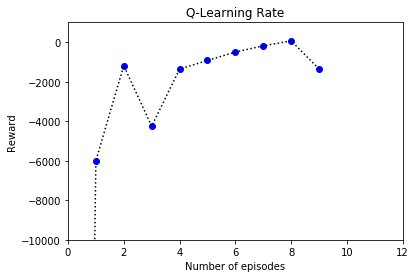

In [4]:
import tkinter as tk
from matplotlib import pylab
from pylab import *

if __name__ == "__main__":
    master = tk.Tk()
    grid_world = GridWorld(20,20,master=master)
    grid_world.scan_grid_and_generate_graph()
    grid_world.print_graph()
    grid_world.create_grid_ui(grid_world.m, grid_world.n, (grid_world.start_x, grid_world.start_y),
                              (grid_world.end_x, grid_world.end_y))

    QL = QLearning(list(range(8)))

    scores, episodes, timesteps = [], [], []

    number_of_episodes = 10
    for episode in range(number_of_episodes):
        
        # reset environment and initialize state
        score = 0
        t_step = 0
        state = grid_world.reset()
        grid_world.is_visited = [[0] * grid_world.m for temp in range(grid_world.n)] # zero m x n grid 
        while True:
            grid_world.render()

            # get action of state from agent
            action = QL.get_action(str(state))
            
            # take action and proceed one step in the environment
            next_state, reward, done = grid_world.step(action)

            # with sample <s,a,r,s'>, agent learns new q function
            QL.learn(str(state), action, reward, str(next_state))
            
            # Print q function values <s,a,r,s'> 
            print("<state:{0} , action:{1} , reward:{2} , next_state:{3}>".format(
                    str(state), str(action), str(reward), str(next_state)))
            grid_world.is_visited[state[0]][state[1]] += 1
            t_step += 1
            state = next_state
            score += reward

            if done:
                scores.append(score)
                episodes.append(episode)
                timesteps.append(t_step)
                print("Total number of timesteps in "+ str(episode) + " episode: "+ str(t_step))
                break
                
    # Plot final results of Q-Learining effectiveness
    
    # Changes of the total reward with every episode
    pylab.plot(episodes, scores, 'bo', label='Reward per Episode')
    pylab.plot(episodes, scores, ':k')
    pylab.xlim(0, 12)
    pylab.ylim(-10000, 1000)
    pylab.xlabel('Number of episodes')
    pylab.ylabel('Reward')
    pylab.title('Q-Learning Rate')

    pylab.savefig("./q_learning10.png")

    # print Q function of all states
    print(QL.q_table)
    

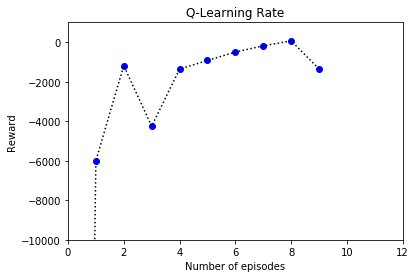

In [5]:
pylab.plot(episodes, scores, 'bo', label='Reward per Episode')
pylab.plot(episodes, scores, ':k')
pylab.xlim(0, 12)
pylab.ylim(-10000, 1000)
pylab.xlabel('Number of episodes')
pylab.ylabel('Reward')
pylab.title('Q-Learning Rate')

pylab.savefig("./q_learning10.png")

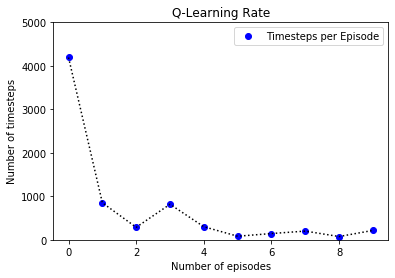

In [6]:
pylab.plot(episodes, timesteps, 'bo', label='Timesteps per Episode')
pylab.plot(episodes, timesteps, ':k')
pylab.legend()
pylab.xlabel('Number of episodes')
pylab.ylabel('Number of timesteps')
pylab.title('Q-Learning Rate')

pylab.ylim(0, 5000)

pylab.savefig("./q_learning11.png")